<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue; text-align: left;">
Recurrent Neural Networks (RNN) - One-Way Modeling
</p>

In [9]:
# Libraries for data manipulation and visualization
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and training
import tensorflow as tf                          # For deep learning framework
from keras.models import Sequential              # For creating sequential models
from keras.layers import Dense, Input, BatchNormalization, Dropout, LeakyReLU, SimpleRNN  # Layers for building neural networks
from keras.regularizers import l2               # For L2 regularization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # For training optimization

# Libraries for evaluation and preprocessing
from sklearn.metrics import (                   # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)
from sklearn.preprocessing import StandardScaler # For standardizing features
from sklearn.model_selection import KFold, train_test_split, PredefinedSplit # For cross-validation and splitting data

import time

# Set seed for reproducibility
GLOBAL_SEED = 50
np.random.seed(GLOBAL_SEED)                      # Seed for NumPy
tf.random.set_seed(GLOBAL_SEED)                  # Seed for TensorFlow

In [10]:
# Time-aware data load (from Data Preparation.ipynb outputs)

base_path = '../../Comprehensive ML - Files & Plots etc'

df_train = pd.read_csv(f"{base_path}/train.csv", parse_dates=['time'])
df_test  = pd.read_csv(f"{base_path}/test.csv", parse_dates=['time'])
fold_assignments = np.load(f"{base_path}/train_folds.npy")

feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity',
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train = df_train[feature_names].to_numpy()
y_train = df_train['PL'].to_numpy()
X_test  = df_test[feature_names].to_numpy()
y_test  = df_test['PL'].to_numpy()

time_train = df_train['time'].to_numpy()
time_test  = df_test['time'].to_numpy()

ps = PredefinedSplit(fold_assignments)  # reuse the time-aware folds

print(f"Train: {len(df_train)} rows, Test: {len(df_test)} rows")
print(f"Train window: {df_train.time.min()} -> {df_train.time.max()}")
print(f"Test window:  {df_test.time.min()} -> {df_test.time.max()}")

Train: 1663627 rows, Test: 415907 rows
Train window: 2024-10-01 00:01:07.420593+00:00 -> 2025-08-12 17:18:53.293125+00:00
Test window:  2025-08-12 17:19:02.126782+00:00 -> 2025-09-30 23:59:55.971870+00:00


In [11]:
# use a fraction of the data (keeps time order) *per fold*. Set USE_SUBSET=False for full data.
USE_SUBSET = False
DATA_FRACTION = 0.25  # fraction of data to keep from each fold

if USE_SUBSET:
    fold_ids = np.unique(fold_assignments[fold_assignments != -1])
    keep_mask = np.zeros(len(df_train), dtype=bool)
    kept_counts = {}

    # keep the first DATA_FRACTION portion within each fold, preserving order
    for fid in fold_ids:
        idx = np.flatnonzero(fold_assignments == fid)
        keep_n = max(1, int(np.ceil(len(idx) * DATA_FRACTION)))
        keep_mask[idx[:keep_n]] = True
        kept_counts[fid] = keep_n

    # (optional) if there are -1 labels in train, subset them too
    if np.any(fold_assignments == -1):
        idx = np.flatnonzero(fold_assignments == -1)
        keep_n = max(1, int(np.ceil(len(idx) * DATA_FRACTION)))
        keep_mask[idx[:keep_n]] = True
        kept_counts['-1'] = keep_n

    df_train = df_train.iloc[keep_mask].copy()
    fold_assignments = fold_assignments[keep_mask]
    # subset test set separately if you still want a fraction
    n_test = max(1, int(np.ceil(len(df_test) * DATA_FRACTION)))
    df_test = df_test.iloc[:n_test].copy()

    print("Using subset per fold:", kept_counts)
    print(f"Train rows kept: {len(df_train)}, Test rows kept: {len(df_test)}")
else:
    print("Using full dataset")

if len(df_train) == 0 or len(df_test) == 0:
    raise ValueError("Subset produced empty data; increase DATA_FRACTION or disable USE_SUBSET.")

# refresh arrays/split objects
X_train = df_train[feature_names].to_numpy()
y_train = df_train["PL"].to_numpy()
X_test = df_test[feature_names].to_numpy()
y_test = df_test["PL"].to_numpy()
time_train = df_train["time"].to_numpy()
time_test = df_test["time"].to_numpy()
ps = PredefinedSplit(fold_assignments)

fold_ids = fold_assignments[fold_assignments != -1]
print("Unique CV fold labels:", np.unique(fold_ids), "count:", np.unique(fold_ids).size)
print("Counts per fold:", np.bincount(fold_ids) if fold_ids.size else "none")

Using full dataset
Unique CV fold labels: [0 1 2 3 4] count: 5
Counts per fold: [554543 277271 277271 277271 277271]


In [12]:
# Scale features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sequence length for RNN
SEQ_LEN = 10

def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        Xs.append(X[i:i + seq_len])
        ys.append(y[i + seq_len - 1])
    return np.array(Xs), np.array(ys)

def build_sequences_by_fold(X, y, fold_assignments, seq_len):
    X_list, y_list, fold_list = [], [], []
    for fid in np.unique(fold_assignments):
        idx = np.flatnonzero(fold_assignments == fid)
        if idx.size < seq_len:
            continue
        X_fold = X[idx]
        y_fold = y[idx]
        X_seq, y_seq = make_sequences(X_fold, y_fold, seq_len)
        X_list.append(X_seq)
        y_list.append(y_seq)
        fold_list.append(np.full(len(y_seq), fid, dtype=int))
    if not X_list:
        raise ValueError("No sequences created; reduce SEQ_LEN or check fold sizes.")
    return np.concatenate(X_list), np.concatenate(y_list), np.concatenate(fold_list)

# Build sequences for training (respecting fold boundaries)
X_train_seq, PL_train_seq, fold_seq = build_sequences_by_fold(
    X_train_scaled, y_train, fold_assignments, SEQ_LEN
)

# Build sequences for test set
if len(X_test_scaled) < SEQ_LEN:
    raise ValueError("Test set shorter than SEQ_LEN; reduce SEQ_LEN or disable subset.")
X_test_seq, PL_test_seq = make_sequences(X_test_scaled, y_test, SEQ_LEN)

# PredefinedSplit for sequence-level CV
ps_seq = PredefinedSplit(fold_seq)

print(f"Train sequences: {X_train_seq.shape}, Test sequences: {X_test_seq.shape}")
print("Sequence fold labels:", np.unique(fold_seq))

Train sequences: (1663582, 10, 10), Test sequences: (415898, 10, 10)
Sequence fold labels: [0 1 2 3 4]


In [ ]:
t0 = time.time()

def create_rnn_model(seq_len, n_features):
    """Creates a one-way RNN model for regression with regularization."""
    model = Sequential()

    # Input layer
    model.add(Input(shape=(seq_len, n_features)))

    # RNN layer
    model.add(SimpleRNN(128, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))

    # Dense block
    model.add(Dense(32, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(16, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


# Instantiate the model
seq_len = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]
model = create_rnn_model(seq_len, n_features)
model.summary()

# Define Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Train the model with Callbacks
history = model.fit(
    X_train_seq,
    PL_train_seq,
    validation_split=0.2,
    epochs=500,
    batch_size=128,
    verbose=1,
    callbacks=[early_stop, reduce_lr],
    shuffle=False
)

t1 = time.time()
print(f"\nModel training completed in {(t1 - t0)/60:.2f} minutes.")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 128)            │        17,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,657 (88.50 KB)

 Trainable params: 22,561 (88.13 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/500
10398/10398 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 2438.4590 - mae: 37.2200 - val_loss: 51.5093 - val_mae: 5.5105 - learning_rate: 0.0010
Epoch 2/500
10398/10398 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 212.7266 - mae: 11.3301 - val_loss: 44.9005 - val_mae: 5.0757 - learning_rate: 0.0010
Epoch 3/500
10398/10398 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 182.0155 - mae: 10.4295 - val_loss: 44.2792 - val_mae: 5.0584 - learning_rate: 0.0010
Epoch 4/500
10398/10398 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 155.1894 - mae: 9.5848 - val_loss: 40.2602 - val_mae: 4.7630 - learning_rate: 0.0010
Epoch 5/500
10398/10398 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 133.3128 - mae: 8.8245 - val_loss: 40.8896 - val_mae: 4.7973 - learning_rate: 0.0010
Epoch 6/500
10398/10398 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 114.6219 - mae: 8.1229 - val_loss: 40.6264 - val_mae: 4.8123 - learning_rate: 0.0010
Epoch 7/500
10398/10398 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 98.3747 - mae: 7.4653 - 

In [14]:
# Evaluate the trained model on training and test data and display metrics in a table

# Evaluate the model on training data
train_loss, train_mae = model.evaluate(X_train_seq, PL_train_seq, verbose=0)

# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test_seq, PL_test_seq, verbose=0)

# Predict path loss for the test set
PL_pred = model.predict(X_test_seq).flatten()

# Calculate additional metrics
rmse_test = np.sqrt(mean_squared_error(PL_test_seq, PL_pred))
r2_test = r2_score(PL_test_seq, PL_pred)
mape_test = mean_absolute_percentage_error(PL_test_seq, PL_pred)
median_ae_test = median_absolute_error(PL_test_seq, PL_pred)

# Create a results DataFrame
results = pd.DataFrame({
    'Metric': ['Training Loss (MSE)', 'Training MAE',
               'Test Loss (MSE)', 'Test MAE',
               'Test RMSE', 'R2 Score',
               'Test MAPE (%)', 'Test Median AE'],
    'Value': [train_loss, train_mae,
              test_loss, test_mae,
              rmse_test, r2_test,
              mape_test * 100, median_ae_test]
})

# Display the results table
print("\nModel Evaluation Metrics:")
display(results)

12997/12997 ━━━━━━━━━━━━━━━━━━━━ 6s 487us/step

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),39.925262
1,Training MAE,4.736033
2,Test Loss (MSE),29.814779
3,Test MAE,3.970526
4,Test RMSE,5.386246
5,R2 Score,0.918163
6,Test MAPE (%),4.620731
7,Test Median AE,3.274660


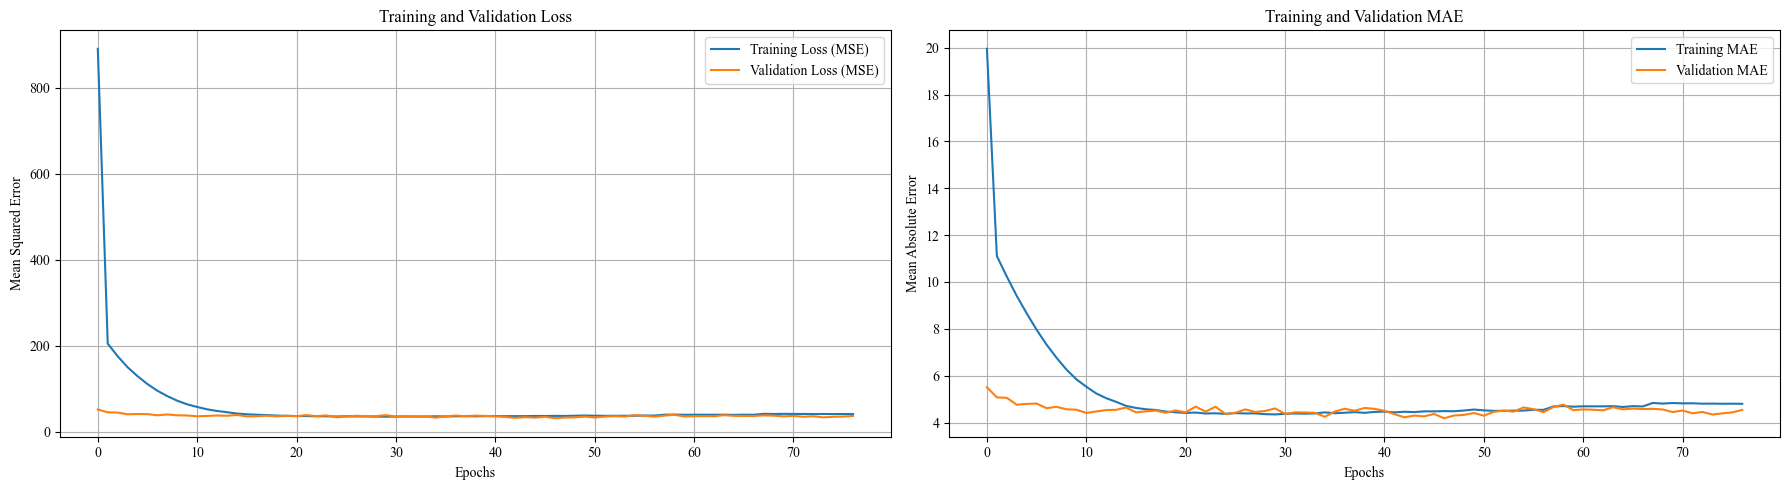

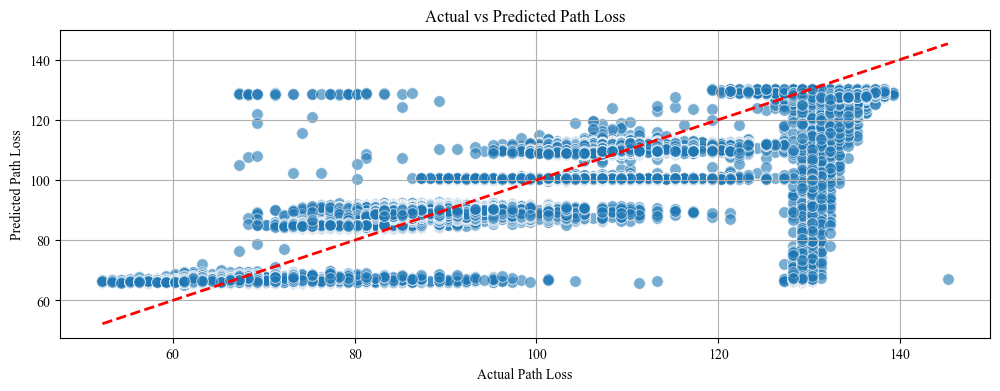

In [15]:
# Visualize training history and model predictions

# Plot training and validation loss
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot predicted vs actual values
plt.figure(figsize=(12, 4))
sns.scatterplot(x=PL_test_seq, y=PL_pred, alpha=0.6, edgecolor='w', s=70)
plt.plot([PL_test_seq.min(), PL_test_seq.max()], [PL_test_seq.min(), PL_test_seq.max()], 'r--', lw=2)
plt.xlabel('Actual Path Loss')
plt.ylabel('Predicted Path Loss')
plt.title('Actual vs Predicted Path Loss')
plt.grid(True)
plt.show()

In [ ]:
t2 = time.time()

# Perform time-aware cross-validation to assess model robustness and display results in a table

seq_len = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

fold = 1
cv_results_list = []

for train_index, val_index in ps_seq.split():
    print(f"Training fold {fold}...")

    # Split data into training and validation for the current fold
    X_train_fold, X_val_fold = X_train_seq[train_index], X_train_seq[val_index]
    PL_train_fold, PL_val_fold = PL_train_seq[train_index], PL_train_seq[val_index]

    # Create a new instance of the model for each fold
    model = create_rnn_model(seq_len, n_features)

    # Define Callbacks
    early_stop_cv = EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True
    )

    reduce_lr_cv = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=0
    )

    # Train the model on the current fold
    history_cv = model.fit(
        X_train_fold,
        PL_train_fold,
        validation_data=(X_val_fold, PL_val_fold),
        epochs=500,
        batch_size=128,
        callbacks=[early_stop_cv, reduce_lr_cv],
        verbose=0,
        shuffle=False
    )

    # Predict path loss for the test set
    PL_pred_cv = model.predict(X_test_seq).flatten()

    # Calculate metrics
    test_loss, test_mae = model.evaluate(X_test_seq, PL_test_seq, verbose=0)
    rmse_cv = np.sqrt(mean_squared_error(PL_test_seq, PL_pred_cv))
    r2_cv = r2_score(PL_test_seq, PL_pred_cv)
    mape_cv = mean_absolute_percentage_error(PL_test_seq, PL_pred_cv)
    median_ae_cv = median_absolute_error(PL_test_seq, PL_pred_cv)

    # Append metrics to the results list
    cv_results_list.append({
        'Fold': fold,
        'Test Loss (MSE)': round(test_loss, 4),
        'Test MAE': round(test_mae, 4),
        'Test RMSE': round(rmse_cv, 4),
        'R2 Score': round(r2_cv, 4),
        'Test MAPE (%)': round(mape_cv * 100, 2),
        'Test Median AE': round(median_ae_cv, 4)
    })

    print(
        f"Fold {fold} - Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}, "
        f"RMSE: {rmse_cv:.4f}, R2: {r2_cv:.4f}, MAPE: {mape_cv*100:.2f}%, "
        f"Median AE: {median_ae_cv:.4f}"
    )
    fold += 1

# Create a DataFrame from the results
cv_results_df = pd.DataFrame(cv_results_list)

# Calculate average and standard deviation for each metric
cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
cv_summary.rename(columns={'index': 'Metric'}, inplace=True)

# Display Cross-Validation Results
print("Time-Aware Cross-Validation Results:")
display(cv_results_df)

print("Cross-Validation Summary:")
display(cv_summary)

t3 = time.time()
print(f"\nTask complete in {(t3 - t2)/60:.2f} minutes.")